In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.special as spec
import scipy.integrate as integrate
import scipy.optimize as opt

In [38]:

#Average of bright and dark counts
def brightDistrobution(Rb, Rd, tb):
    x = (Rb+Rd)*tb
    return x

#Dark counts
def darkDistrobution(Rd, tb):
    x = Rd*tb
    return x

#Bright state detection event Poisson distribution
def Bo(N, Bmean):
    X = (np.power(Bmean,N)) * (np.exp(-1*Bmean)) / spec.factorial(N)
    return X

#Dark state Poisson distribution + extra events due to decay from bright to dark as time increases
def Do(N, Dmean,Rb,Rd,tb,tau):
    X = (np.exp(-1*tb/tau)*(np.power(Dmean,N))*(np.exp(-1*Dmean)) / spec.factorial(N)) + Xo(N,Rb,Rd,tb,tau)
    return X

#Decay term X naught
def Xo(N,RB,RD,tb,tau):
    X0 = []
    for n in N:
        X0 = np.append(X0, (integrate.quad(X_integrand, RD*tb, (RB+RD)*tb, args=(n,RB,RD,tau,tb)))[0])
    return X0

#Integrand to be integrated over all lambdas, where lambda(t) is the mean of the poisson distrobution of the number of counts (n) recorded in bin time (tb) when an ion decays at time t (0 < t < tb)
def X_integrand(l,n,RB,RD,tau,tb):
    return (1/(RB*tau))*np.exp((l-((RD+RB)*tb))/(RB*tau))*np.power(l,n)*np.exp(-1*l)/spec.factorial(n)

![alt text](LambdaFunction.PNG)

![alt text](NoDecay.PNG)

In [39]:

#Discrete integrand under the curve of D naught right of the critical count nc (distinguishing point between bright and dark state)
def errorD(Rb,Rd,tb,N,tau): 
    return np.sum(((np.power(Rd*tb,N)) * (np.exp(-1*(Rd*tb))) / spec.factorial(N)) + Xo(N,Rb,Rd,tb,tau))

#Discrete integrand under the curve of B naught to be integrated left of the critical count nc
def errorB(Rb,Rd,tb,NB):
    return np.sum((np.power((Rb+Rd)*tb,NB)) * (np.exp(-1*((Rb+Rd)*tb))) / spec.factorial(NB))

![alt text](AndorSpecTable.png)

In [40]:
#Model Settings
nMax = 100 #Max number of detection counts we want to consider
tbMax = .001 #Max bin time we want to consider in s
nStep = .1 #n granularity (really should be 1 -- there is or isn't a count event, no partial events)
tStep = .00001 #time granularity in s (affects curve accuracy)

#Real Variables
tau = 1.167 #tau = bright state decay time in s (for Ca40 ions)
Rb = 55800 #Bright state fluoresence rate in s^-1
DarkCounts = [1000] #Detector Dark Counts

#DarkCounts  = np.arange(start=0,stop=5001,step=500)

In [41]:
#Array of possible detection counts
N = np.arange(start=0,stop=nMax,step=nStep)
#Bin times we're considering
BT = np.arange(start=0,stop=tbMax,step=tStep)
BrightEArrays =[]
DarkEArrays = []
AvgEArrays = []
#Different cameras/setups have different dark count rates (Rd)
for Rd in DarkCounts:
    #For each potential bin time, the ideal count cutoff (nc) between a dark and bright detection is determined
    darkE = np.empty(0)
    brightE = np.empty(0)

    for tb in BT:
        Bmean = brightDistrobution(Rb,Rd,tb)
        BM = np.full(np.int_(nMax/nStep),Bmean)
        Dmean = darkDistrobution(Rd,tb)
        DM = np.full(np.int_(nMax/nStep),Dmean)

        #n counts in tb from bright
        B0 = Bo(N,BM)
        #n counts in tb from dark
        D0 = Do(N,DM,Rb,Rd,tb,tau)

        #determine count threshold nc
        nc = 0
        lastDiff = np.abs(B0[0]-D0[0])
        for i, item in enumerate(B0):
            diff = (B0[i]-D0[i])
            nc = i
            if((diff>lastDiff) and diff>0):
                break
            lastDiff = diff
        nc=nc*nStep

        NB = N[np.where(N<=nc)] #Integral range for eB
        ND = N[np.where(N>=nc)] #Integral range for eD

        brightE = np.append(brightE, errorB(Rb,Rd,tb,NB))
        darkE = np.append(darkE, errorD(Rb,Rd,tb,ND,tau))
    BrightEArrays.append(brightE.tolist())
    DarkEArrays.append(darkE.tolist())
    avgE = (darkE+brightE)/2
    AvgEArrays.append(avgE.tolist())
#print(eArrays)

Text(0.5, 1.0, 'Error Rates at 1000 Dark Counts per Second')

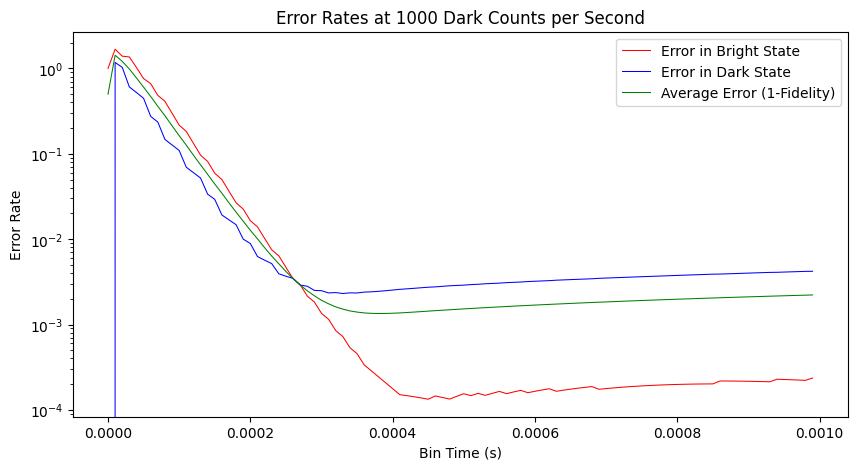

In [42]:
#Plotting the error rate over bin times after choosing an ideal nc at each bin time
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
for Y in BrightEArrays:
    ax1.plot(BT, Y, lw=0.75, c="r", label = "Error in Bright State" )
for Y in DarkEArrays:
    ax1.plot(BT, Y, lw=0.75, c="b", label = "Error in Dark State")
for Y in AvgEArrays:
    ax1.plot(BT, Y, lw=0.75, c="g", label = "Average Error (1-Fidelity)")
ax1.set_ylabel("Error Rate")
ax1.set_xlabel("Bin Time (s)")
ax1.legend()
plt.yscale('log')
plt.title("Error Rates at " + str(DarkCounts[0]) + " Dark Counts per Second")

Text(0.5, 1.0, 'Fidelity at [1000] Dark Counts per Second')

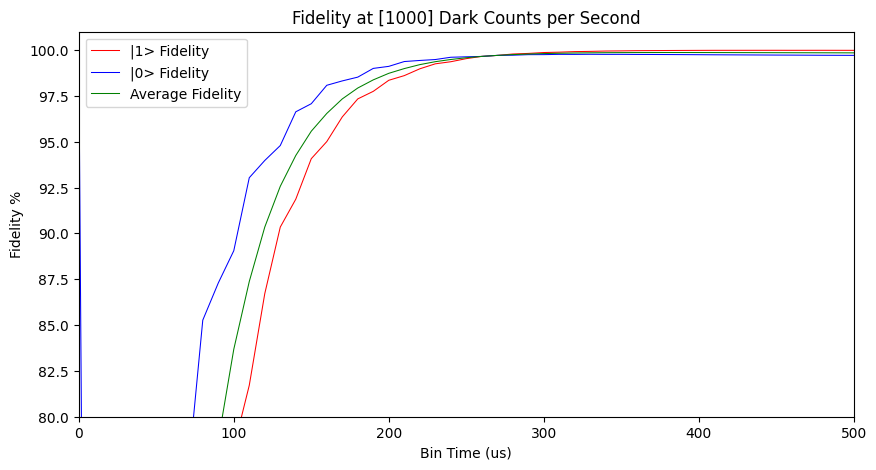

In [43]:
#Plotting the fidelity as a function of dark rate
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
for Y in BrightEArrays:
    ax1.plot(BT*1000000, 100*(1-np.array(Y)), lw=0.75, c="r", label = "|1> Fidelity" )
for Y in DarkEArrays:
    ax1.plot(BT*1000000, 100*(1-np.array(Y)), lw=0.75, c="b", label = "|0> Fidelity")
for Y in AvgEArrays:
    ax1.plot(BT*1000000, 100*(1-np.array(Y)), lw=0.75, c="g", label = "Average Fidelity")
ax1.set_ylabel("Fidelity %")
ax1.set_xlabel("Bin Time (us)")
ax1.set_xlim(0,500)
ax1.set_ylim(80,101)
ax1.legend()
plt.title("Fidelity at " + str(DarkCounts) + " Dark Counts per Second")